### DMP-01 Solution

#### import all the needed packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# To display multiple outputs from the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
!python -V

Python 3.8.10


#### Use the adjusted close price of MSFT from January 2nd 2015 to April 30th 2020 for questions 1 to 4.

In [2]:
ticker = "MSFT"
start = datetime(2015, 1, 2)
end = datetime(2020, 4, 30)

In [3]:
def download_daily_data(ticker, start, end):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified.
    """
    data = yf.download(ticker, start, end)
    
    return data

In [4]:
df = download_daily_data(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()
df.tail()
df.shape

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,41.013313,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.636162,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,40.039734,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,40.548450,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.741314,29645200


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,167.933334,32790800
2020-04-24,172.059998,174.559998,170.710007,174.550003,170.999695,34277600
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509842,33194400
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356049,34392700
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821091,51286600


(1340, 6)

### __Q1: Try out the ‘Big Moves Monday’ strategy on the above data with the standard conditions as taught in the class. Now back-test the strategy again but this time tweak one of the conditions such that the ‘ibs’ value must be lower than 0.8. Compare the results(total return) with the standard conditions case. Comment on the results.__

In [6]:
df1 = df.copy()

In [7]:
def compute_daily_returns(data):
    """ 
    The function computes daily log returns based on the Adjusted Close prices in the pandas DataFrame
    and stores it in a column  called 'cc_returns'.
    """
    data['cc_returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    
    return data

In [8]:
def compute_indicators(data):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Big Moves on Mondays" trading strategy.
    """
    # Columns created to check condition 1
    data['day'] = data.index.day_name()
    data['prev_day'] = data['day'].shift(1)
    data['four_days_after'] = data['day'].shift(-4)
    
    # Columns created to check condition 2
    data['relative_range'] = (data['High'] - data['Low']) / data['Adj Close']
    data['rel_range_ma'] = data['relative_range'].rolling(window=25).mean()
    
    # Column created to check condition 3
    data['ibs'] = (data['Adj Close'] - data['Low']) / (data['High'] - data['Low'])
    
    return data

In [9]:
def backtest_strategy(data, ibs_threshold= 0.3):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Big Moves on Mondays" trading strategy. 
    It then computes the strategy returns.
    IMPORTANT: To be run ONLY after the function compute_indicators.
    """
    data['condition1'] = np.where((data['day'] == 'Monday') 
                            & (data['prev_day'] == 'Friday') 
                            & (data['four_days_after'] == 'Friday'), 
                            1, 0)
    
    data['condition2'] = np.where((1 - data['Adj Close'] / data['Adj Close'].shift(1))
                                  >= 0.25 * data['rel_range_ma'], 1, 0)
    
    data['condition3'] = np.where(data['ibs'] < ibs_threshold, 1, 0)
    
    data['signal'] = np.where((data['condition1']==1) 
                        & (data['condition2']==1) 
                        & (data['condition3']==1), 
                        1, 0)
    
    # The below two statements ensures that we can directly calculate strategy returns by multiplying the 
    # columns 'position' and 'cc_returns'
    data['signal'] = data['signal'].shift(1)
    
    data['position'] = data['signal'].replace(to_replace=0, method='ffill', limit=3)
    
    data['strategy_returns'] = data['cc_returns'] * data['position']
    
    return data

In [10]:
def show_backtesting_results(data):
    """
    The function displays the cumulative returns from the trading strategy and a buy-and-hold strategy. 
    It also plots a chart showing both returns and position over time.
    IMPORTANT: To be run ONLY after the function backtest_strategy.
    """

    print('Buy and hold returns: ', np.round(data['cc_returns'].cumsum()[-1], 2))
    print('Strategy returns: ', np.round(data['strategy_returns'].cumsum()[-1], 2))
    
    data[['cc_returns', 'strategy_returns']] = data[['cc_returns', 'strategy_returns']].cumsum()
    data[['cc_returns', 'strategy_returns']].plot(grid=True, figsize=(12, 8));

#### Let's use the above functions to backtest the same strategy for two different values of the ibs indicator (to avoid code repetition we have parametrized the backtest_strategy function to accept ibs as an input parameter with a default value of 0.3)

In [11]:
# let's make sure that there aren't any NaN or zero values
df1["Adj Close"].isnull().values.any()
count = (df1["Adj Close"] == 0).sum()
print("Count of zeros in Column  'AdjClose' : ", count)

False

Count of zeros in Column  'AdjClose' :  0


In [12]:
df1 = compute_daily_returns(df1)
df1.tail(3)
df1.shape

,Open,High,Low,Close,Adj Close,Volume,cc_returns
Date,,,,,,,
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509842,33194400,-0.002869
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356049,34392700,-0.024663
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821091,51286600,0.043896


(1340, 7)

In [13]:
df1 = compute_indicators(df1)
df1.tail(3)
df1.shape

,Open,High,Low,Close,Adj Close,Volume,cc_returns,day,prev_day,four_days_after,relative_range,rel_range_ma,ibs
Date,,,,,,,,,,,,,
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509842,33194400,-0.002869,Monday,Friday,NaN,0.021113,0.037599,-0.775047
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356049,34392700,-0.024663,Tuesday,Monday,NaN,0.037750,0.036692,-0.483113
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821091,51286600,0.043896,Wednesday,Tuesday,NaN,0.033368,0.035733,0.334671


(1340, 13)

In [14]:
df_strategyA= df1.copy()
df_strategyB= df1.copy()
# standard strategy with ibs < 0.3
df1_strategyA = backtest_strategy(df_strategyA)
# standard strategy with ibs < 0.8
df1_strategyB = backtest_strategy(df_strategyB, ibs_threshold=0.8)

Buy and hold returns:  1.44
Strategy returns:  0.74


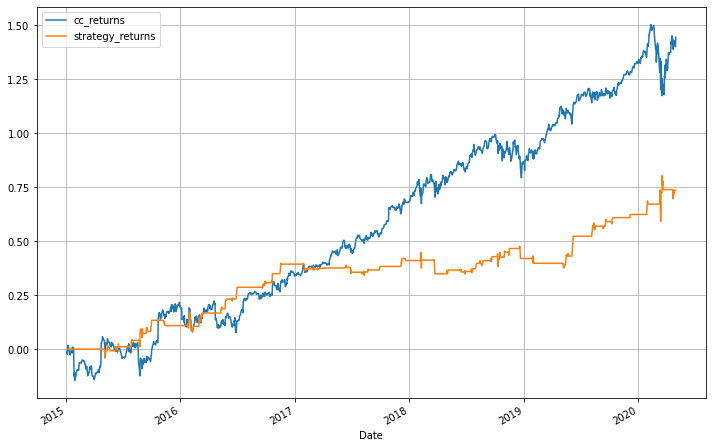

In [15]:
show_backtesting_results(df1_strategyA)

Buy and hold returns:  1.44
Strategy returns:  0.68


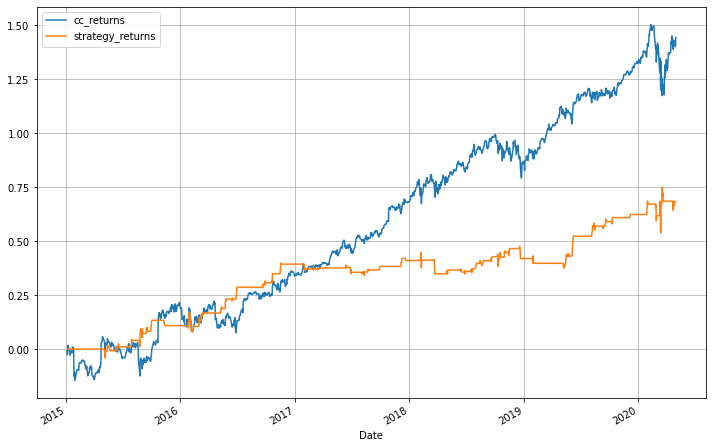

In [16]:
show_backtesting_results(df1_strategyB)

#### __COMMENTS:__ __Both strategies are worse than traditional Buy&Hold (before 2017 they were quite close to each other). Standard strategy (ibs<0.3) performs slightly better than modified strategy (ibs<0.8) 74% vs. 68%__ __Overall they are not worth it!__

### __Q2: You have seen a strategy based on MACD indicator in the class. Now back-test the following strategy based on Bollinger bands:__

#### (i) Create 20-day (+/- 2 standard deviations) Bollinger bands on the adjusted close price for the above equity

In [17]:
df = download_daily_data(ticker, start, end)
df.tail(3)
df.shape

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509872,33194400
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356094,34392700
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821075,51286600


(1340, 6)

In [18]:
# let's use the Ta-lib library
from talib import BBANDS
BBANDS?

Docstring:
BBANDS(real[, timeperiod=?, nbdevup=?, nbdevdn=?, matype=?])

Bollinger Bands (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 5
    nbdevup: 2
    nbdevdn: 2
    matype: 0 (Simple Moving Average)
Outputs:
    upperband
    middleband
    lowerband
Type:      function


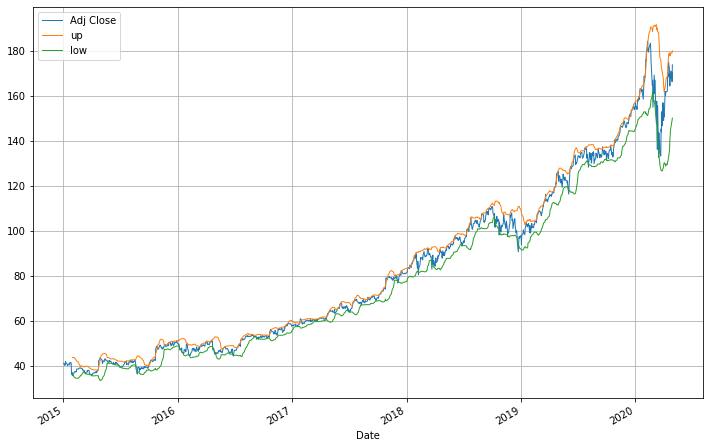

In [19]:
# let's calculate the Bollinger Bands and plot them
dfbb=df.copy()
adj_close= dfbb["Adj Close"]
# we don't need the mid band and use '_' to esclude the column
dfbb['up'], _, dfbb['low'] = BBANDS(adj_close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
dfbb[['Adj Close', 'up', 'low']].plot(grid=True, linewidth=1, figsize=(12, 8));

In [20]:
dfbb.tail()
dfbb.shape

,Open,High,Low,Close,Adj Close,Volume,up,low
Date,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,167.933334,32790800,178.273661,144.870170
2020-04-24,172.059998,174.559998,170.710007,174.550003,170.999680,34277600,179.164718,145.785607
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509872,33194400,179.020660,148.315141
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356094,34392700,179.213691,149.060627
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821075,51286600,180.061671,150.144534


(1340, 8)

#### (ii) Buy when the price crosses the lower band from top and hold until the price crosses the upper band from below the next time.
#### (iii) Sell when the price crosses the upper band from below and hold until the price crosses the lower band from top the next time.
#### (iv) Once we get into a trade, we always have an open position at all times.
##### __NOTE: we are not taking into consideration look-ahead bias (to avoid the problem we may enter the position 5 minutes before the close of the trading session or we could enter the position at the 'Open' of the next day. For simplicity let's go with the first approach)__

In [21]:
def compute_indicators(data):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Bollinger Bands" trading strategy.
    """
    # Columns created to check condition (ii) & (iii):
    data['previous Adj Close'] = data['Adj Close'].shift(1)
    data['up_prev_day'] = data['up'].shift(1)
    data['low_prev_day'] = data['low'].shift(1)
    
    # condition (ii):
    data['buy_signal'] = np.where((data['previous Adj Close'] >  data['low_prev_day']) 
                        & (data['Adj Close'] < data['low']), 
                            1, 0)
    
    # condition (iii):
    data['sell_signal'] = np.where((data['previous Adj Close'] <  data['up_prev_day']) 
                          & (data['Adj Close'] > data['up']), 
                            -1, 0)
    
    # condition (iv):
    data['signal'] = data['buy_signal'] + data['sell_signal']
    data['position'] = data['signal'].replace(to_replace=0, method='ffill')
    
    return data

In [22]:
#df1=compute_daily_returns(df1)
dfbb= compute_indicators(dfbb)
dfbb.tail()
dfbb['signal'].value_counts()
dfbb['position'].value_counts()
dfbb.shape

,Open,High,Low,Close,Adj Close,Volume,up,low,previous Adj Close,up_prev_day,low_prev_day,buy_signal,sell_signal,signal,position
Date,,,,,,,,,,,,,,,
2020-04-23,174.110001,175.059998,170.910004,171.419998,167.933334,32790800,178.273661,144.870170,169.990631,178.464087,142.279576,0,0,0,1
2020-04-24,172.059998,174.559998,170.710007,174.550003,170.999680,34277600,179.164718,145.785607,167.933334,178.273661,144.870170,0,0,0,1
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509872,33194400,179.020660,148.315141,170.999680,179.164718,145.785607,0,0,0,1
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356094,34392700,179.213691,149.060627,170.509872,179.020660,148.315141,0,0,0,1
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821075,51286600,180.061671,150.144534,166.356094,179.213691,149.060627,0,0,0,1


 0    1261
-1      55
 1      24
Name: signal, dtype: int64

-1    827
 1    466
 0     47
Name: position, dtype: int64

(1340, 15)

In [23]:
# uncomment these lines to check for buy/sell conditions
#df1.iloc[45:50]
#df1.iloc[73:80]
#df1.iloc[102:110]

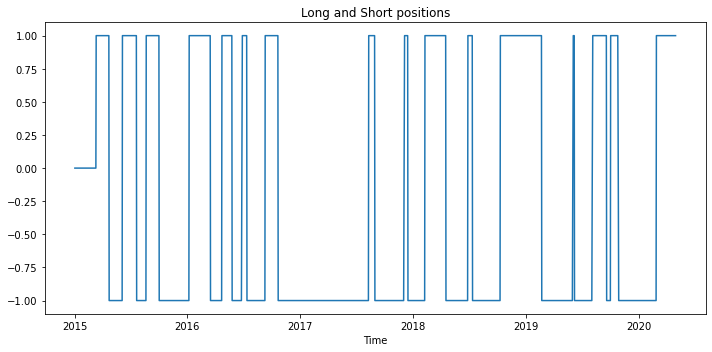

In [24]:
# plot positions
plt.figure(figsize=(10, 5))
plt.plot(dfbb['position'])
plt.title("Long and Short positions")
plt.xlabel('Time')
plt.tight_layout()
plt.show();

In [25]:
# let's calculate the strategy returns
def backtest_strategy(data):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Bollinger Bands" trading strategy. 
    It then computes the strategy returns.
    IMPORTANT: To be run ONLY after the function compute_indicators.
    """
    
    data['bnh_returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data['bbands_returns'] = data['bnh_returns'] * data['position'].shift(1)

    data[['bnh_returns', 'bbands_returns']].cumsum().plot(grid=True, figsize=(12, 8));
    
    print('Buy and hold returns: ', np.round(data['bnh_returns'].cumsum()[-1], 2))
    print('Bollinger Bands strategy returns: ', np.round(data['bbands_returns'].cumsum()[-1], 2))
    
    return data

Buy and hold returns:  1.44
Bollinger Bands strategy returns:  0.5


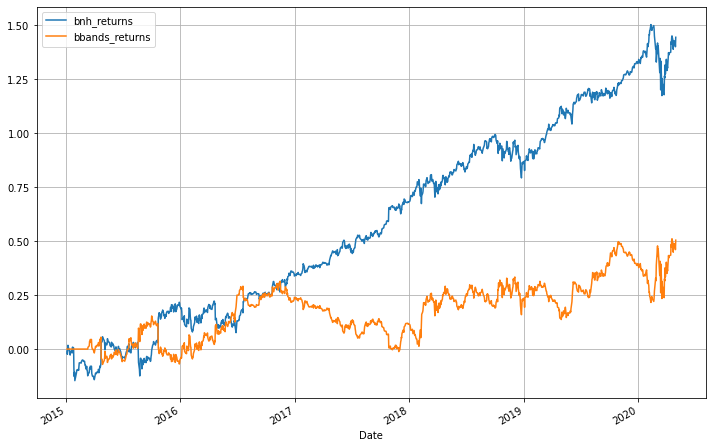

In [26]:
dfbb= backtest_strategy(dfbb)

In [27]:
# uncomment these lines to check for buy/sell conditions
#df1.iloc[43:50]
#df1.iloc[73:80]
#df1.iloc[102:110]

#### Compare the total returns of the above strategy with a simple ‘buy & hold’ strategy. Comment on your findings.

#### __COMMENTS__: The standard bollinger Band strategy is by far worse (+50%) than the Buy&Hold strategy (+144%). Th BB strategy is based on the condition that prices follow the Normal distribution while generally the distribution of the Returns has fatter tails than the normal one.

#### Q3: Write a customized function that computes returns for the exponential moving average (EMA) strategy (discussed in class) for different windows(spans). Find the optimal value of span between 1 and 30 which produces the best overall total return. 

In [28]:
# in order to speed up the computation we will make use of the "amazing/nest-asyncio" asyncio library
# and compare it with a standard synchronous implementation
!pip install nest-asyncio
from time import time
import nest_asyncio
nest_asyncio.apply()
import asyncio

In [29]:
df = download_daily_data(ticker, start, end)
df.tail(3)
df.shape
dfexp = df.copy()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509842,33194400
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356094,34392700
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821091,51286600


(1340, 6)

In [30]:
# ASYNCHRONOUS IMPLEMENTATION

async def ema_calculation(df, ema):
    df["cc_returns"] = df["Adj Close"].pct_change()
    df["ema"] = df["Adj Close"].ewm(span=ema, adjust=False).mean()
    df["position"] = np.where((df["Adj Close"] > df["ema"]), 1, 0)
    df["position"] = df["position"].shift(1)
    df["strategy_returns"] = df["cc_returns"] * df["position"]
    df["strategy_returns"] = 1 + df["strategy_returns"]
    print(f"Strategy returns for ema = {ema}: {np.round(df['strategy_returns'].cumprod()[-1], 2)}")
    
    
async def main():
    # tasks = await task_list()
    await asyncio.gather(
        *[ema_calculation(dfexp, i) for i in range(1, 31)], return_exceptions=True
    )

# main loop
loop = asyncio.get_event_loop()
start = time()
try:
    loop.run_until_complete(main())
except KeyboardInterrupt as e:
    print("shutting down", e)

print(f"Asynchronous execution takes: {(time() - start):.3f} sec.")

Strategy returns for ema = 1: 1.0
Strategy returns for ema = 2: 1.19
Strategy returns for ema = 3: 0.98
Strategy returns for ema = 4: 1.02
Strategy returns for ema = 5: 0.89
Strategy returns for ema = 6: 0.9
Strategy returns for ema = 7: 0.95
Strategy returns for ema = 8: 0.83
Strategy returns for ema = 9: 0.91
Strategy returns for ema = 10: 1.03
Strategy returns for ema = 11: 1.28
Strategy returns for ema = 12: 1.31
Strategy returns for ema = 13: 1.37
Strategy returns for ema = 14: 1.54
Strategy returns for ema = 15: 1.5
Strategy returns for ema = 16: 1.42
Strategy returns for ema = 17: 1.38
Strategy returns for ema = 18: 1.41
Strategy returns for ema = 19: 1.4
Strategy returns for ema = 20: 1.35
Strategy returns for ema = 21: 1.22
Strategy returns for ema = 22: 1.23
Strategy returns for ema = 23: 1.17
Strategy returns for ema = 24: 1.2
Strategy returns for ema = 25: 1.3
Strategy returns for ema = 26: 1.33
Strategy returns for ema = 27: 1.26
Strategy returns for ema = 28: 1.3
Strategy

In [49]:
# SYNCHRONOUS IMPLEMENTATION

def ema_calculation(df, ema):
    df["cc_returns"] = df["Adj Close"].pct_change()
    df["ema"] = df["Adj Close"].ewm(span=ema, adjust=False).mean()
    df["position"] = np.where((df["Adj Close"] > df["ema"]), 1, 0)
    df["position"] = df["position"].shift(1)
    df["strategy_returns"] = df["cc_returns"] * df["position"]
    df["strategy_returns"] = 1 + df["strategy_returns"]
    print(f"Strategy returns for ema = {ema}: {np.round(df['strategy_returns'].cumprod()[-1], 2)}")
    return np.round(df['strategy_returns'].cumprod()[-1], 2)

            
returns = [] 
start = time()
for i in range(1, 31):
    strategy_return = ema_calculation(dfexp, i)
    returns.append((i, strategy_return))

optimal_param = max(returns, key=lambda item: item[1])
    
print(f"\nOptimal parameter for the EMA Strategy is: {optimal_param[0]}")
print(f"Synchronous execution takes: {(time() - start):.3f} sec.")

Strategy returns for ema = 1: 1.0
Strategy returns for ema = 2: 1.19
Strategy returns for ema = 3: 0.98
Strategy returns for ema = 4: 1.02
Strategy returns for ema = 5: 0.89
Strategy returns for ema = 6: 0.9
Strategy returns for ema = 7: 0.95
Strategy returns for ema = 8: 0.83
Strategy returns for ema = 9: 0.91
Strategy returns for ema = 10: 1.03
Strategy returns for ema = 11: 1.28
Strategy returns for ema = 12: 1.31
Strategy returns for ema = 13: 1.37
Strategy returns for ema = 14: 1.54
Strategy returns for ema = 15: 1.5
Strategy returns for ema = 16: 1.42
Strategy returns for ema = 17: 1.38
Strategy returns for ema = 18: 1.41
Strategy returns for ema = 19: 1.4
Strategy returns for ema = 20: 1.35
Strategy returns for ema = 21: 1.22
Strategy returns for ema = 22: 1.23
Strategy returns for ema = 23: 1.17
Strategy returns for ema = 24: 1.2
Strategy returns for ema = 25: 1.3
Strategy returns for ema = 26: 1.33
Strategy returns for ema = 27: 1.26
Strategy returns for ema = 28: 1.3
Strategy

In [48]:
dfexp_opt= df.copy()
ema_calculation(dfexp_opt, optimal_param[0])
dfexp_opt.shape


Strategy returns for ema = 14: 1.54


1.54

(1340, 10)

In [ ]:
dfexp_opt[['strategy_returns']].cumprod().plot(grid=True, figsize=(15, 8));

#### __COMMENTS__: We can see that the optimal parameter that produces the maximum return for the EMA is with 14 days. The strategy gives us 54% of return.
##### NOTE: There is not much difference in performance between the synchronous and asynchronous implementation since we are considering only 1.340 samples. The superior performance of the asynchronous library is noticeable when processing large quantity of data.

#### Q4: The moving average crossover (MAC) code is implemented where we always have an open position. Calculate returns where short selling is not allowed. Plot a graph comparing returns from buy-and-hold, no short selling, and the one we did in class. Comment on your results.

In [ ]:
def download_daily_data(ticker, start, end):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified.
    """
    data = yf.download(ticker, start, end)
    
    return data

In [ ]:
ticker = "MSFT"
start = datetime(2015, 1, 2)
end = datetime(2020, 4, 30)
df = download_daily_data(ticker, start, end)
df.tail(3)
df.shape
df_macd = df.copy()

In [ ]:
def compute_indicators(data):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "MACD" trading strategies.
    """
    data['ema26'] = data['Adj Close'].ewm(span=26, adjust=False).mean()
    data['ema12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()
    data['MACD'] = data['ema12'] - data['ema26']
    
    data['signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    data['position_buy_and_sell'] = np.where(data['MACD'] > data['signal'], 1, -1)
    data['position_buy_and_sell'] = data['position_buy_and_sell'].shift(1)

    data['position_buy_only'] = np.where(data['MACD'] > data['signal'], 1, 0)
    data['position_buy_only'] = data['position_buy_only'].shift(1)
    
    return data

In [ ]:
# let's calculate the strategies returns
def backtest_strategy(data):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Bollinger Bands" trading strategy. 
    It then computes the strategy returns.
    IMPORTANT: To be run ONLY after the function compute_indicators.
    """
    
    data['cc_returns'] = data['Adj Close'].pct_change()
    data['buy_and_sell_returns'] = data['cc_returns'] * data['position_buy_and_sell']
    data['buy_only_returns'] = data['cc_returns'] * data['position_buy_only']
    
    data['cum_buy_and_hold_returns'] = (1 + data['cc_returns']).cumprod()
    data['cum_buy_sell_returns'] = (1 + data['buy_and_sell_returns']).cumprod()
    data['cum_buy_only_returns'] = (1 + data['buy_only_returns']).cumprod()
    
    data[['cum_buy_and_hold_returns', 'cum_buy_sell_returns','cum_buy_only_returns']].plot(figsize=(12, 8), grid=True)
    
    print('Strategy Buy and hold returns: ', np.round((1 + data['cc_returns']).cumprod()[-1], 2))
    print('Strategy MACD buy and sell returns: ', np.round((1 + data['buy_and_sell_returns']).cumprod()[-1], 2))
    print('Strategy MACD buy only returns: ', np.round((1 + data['buy_only_returns']).cumprod()[-1], 2))
    
    return data

In [ ]:
df_macd = compute_indicators(df_macd)

In [ ]:
df_macd = backtest_strategy(df_macd)

#### Q5: Download the data for the following companies TSLA, NFLX, AMZN, GOOG and CVX using the code for automatically downloading multiple stocks from January 1st 2015 to April 30th 2020.  You can use Yahoo Finance for downloading the data.

##### For the above mentioned time period:
> a) Compute the daily returns (assuming you buy at open and sell at close) every day. <br>
> b) Compute the hit ratio for each of them (recall that the hit ratio is the ratio of number of positive trades to total number of trades). <br>
> c) Compute the cumulative returns for each of them. <br>
##### Plot them graphically and comment on your results.

In [ ]:
tickers = ["TSLA", "NFLX", "AMZN", "GOOG", "CVX"]
#tickers = ["TSLA", 'NFLX']
start = datetime(2015, 1, 1)
end = datetime(2020, 4, 30)

def download_daily_data(ticker, start, end):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified.
    """
    data = yf.download(ticker, start, end)
    
    return data

def compute_daily_returns(data):
    """ 
    Compute the daily returns (buy at open and sell at close) every day.
    """
    
    data['oc_returns'] = data['Close'] / data['Open'] -1
    
    return data

def compute_hit_ratio(data):
    """ 
    Compute the hit ratio of data
    (hit ratio is the ratio of number of positive trades to total number of trades).
    """
    data['positive_trades'] =  np.where((data['oc_returns'] > 0), 1, 0)
    data["cum_positive_trades"] = data['positive_trades'].cumsum()
    hit_ratio =  (data.iloc[-1, data.columns.get_loc("cum_positive_trades")] / data.shape[0]) * 100
    print(f"Hit Ratio for ticker {ticker} is: {hit_ratio:.2f}%")
    
    return data

def compute_cumulative_returns(data):
    """ 
    Compute the cumulative returns of data
    
    """
    data["strategy_returns"] = 1 + data['oc_returns']
    data[ticker + "_returns"] = data['strategy_returns'].cumprod()
    print(f"Strategy Return for ticker {ticker} is: {data['strategy_returns'].cumprod()[-1]:.2f}")
    
    return data

def plot_and_compare(dict_of_tickers):
    """ 
    Plot the cumulative returns of data from a dict of tickers
    
    """
    for _, values in dict_of_tickers.items():
        values.plot(grid=True, figsize=(15, 10));
    
    plt.legend(loc="upper left")
    plt.show()
    

dict_of_tickers = {}
for ticker in tickers:
    
    data = download_daily_data(ticker, start, end)
    data = compute_daily_returns(data)
    data = compute_hit_ratio(data)
    data = compute_cumulative_returns(data)
    dict_of_tickers[ticker] = data[ticker + "_returns"]

plot_and_compare(dict_of_tickers)

#### __COMMENTS__: From the graph above we can see that the stocks that performed best were TSLA (Tesla) and NFLX (NetFlix) with an whopping Return of 85% over the period. The were followed by Google with a 54% Return. The remaining stocks were not worth the investment since they produced negative returns. It's worth mentioning that NFLX outperformed by far the others up until late 2018.
#### As for the hit ratio of the stocks they are similar to each other but with very different performance.
##### __NOTE: we are not taking into consideration look-ahead bias (to avoid the problem we may enter the position 5 minutes before the close of the trading session or we could enter the position at the 'Open' of the next day. For simplicity let's go with the first approach)__

### __OPTIONAL__:

#### Q6: Try creating the simple/ full tear sheets using the pyfolio library for questions 1 to 4. Compare various performance and risk metrics for the EMA, the MAC and the Bollinger band strategy.

In [ ]:
import pyfolio as pf

### __Performance for EMA strategy__

In [ ]:
df = download_daily_data(ticker, start, end)
df.tail(3)
df.shape
dfexp = df.copy()

In [ ]:
def ema_calculation(df, ema):
    df["cc_returns"] = df["Adj Close"].pct_change()
    df["ema"] = df["Adj Close"].ewm(span=ema, adjust=False).mean()
    df["position"] = np.where((df["Adj Close"] > df["ema"]), 1, 0)
    df["position"] = df["position"].shift(1)
    df["strategy_returns"] = df["cc_returns"] * df["position"]
    df["strategy_returns"] = 1 + df["strategy_returns"]
    print(f"Strategy returns for ema = {ema}: {np.round(df['strategy_returns'].cumprod()[-1], 2)}")

# use of optimal ema loockback
ema_calculation(dfexp, ema=14)

In [ ]:
pf.create_full_tear_sheet(dfexp["strategy_returns"],benchmark_rets=None)

### __Performance for MACD strategies__

In [ ]:
pf.create_full_tear_sheet(df_macd["cc_returns"],benchmark_rets=None)

In [ ]:
pf.create_full_tear_sheet(df_macd["buy_and_sell_returns"],benchmark_rets=None)

In [ ]:
pf.create_full_tear_sheet(df_macd["buy_only_returns"],benchmark_rets=None)

#### Q7: Install the TA-lib package. You can go through the attached document to get it installed.

In [ ]:
import talib